A continuación se muestra una matriz de expresión genética:

In [403]:
genexp0<-read.csv("practica/GEMatrixFiltered.csv", col.names=c("cc",paste0("c",1:481)))
#head(genexp0)
diagnosis<-as.factor(substr(genexp0[,1],1,1))
#diagnosis
genexp<-genexp0[,2:ncol(genexp0)]
#head(genexp)
options(repr.plot.height=4,repr.plot.width=6)

In [215]:
# length(diagnosis)
# boxplot(genexp0)
# ncol(genexp)
# nrow(genexp)

### Limpieza de datos:

* Normalizar
* ¿Existen outliers? Tratamiento de Outliers

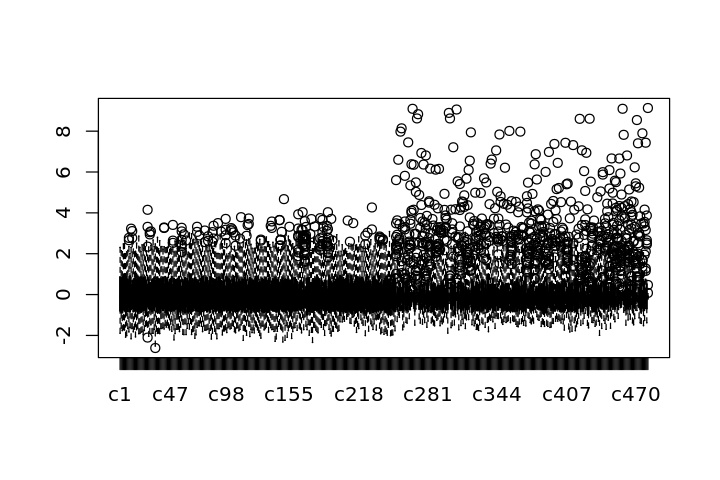

In [281]:
library(pracma)

mnCols<-repmat(colMeans(genexp),n = nrow(genexp),m=1)
sdCols<-repmat(sapply(genexp, sd,na.rm=T),n = nrow(genexp),m=1)
genexp_norm<-(genexp-mnCols)/sdCols

boxplot(genexp_norm)
#head(genexp_norm)

In [496]:
'Parece que existen outliers a partir de la segunda mitad.'
'Sin embargo, he comprobado que tratando los datos como outliers (poniendo los puntos sobresaliente como maximos) no mejoraban las prestaciones de la regresion logistica'
'Por tanto, dejare los datos normalizados como estan ya que al tratarse de datos referidos a mutaciones en los genes es recomendable no tratarlos como outliers a no ser que mejore en una cantidad significativa las prestaciones del modelo'

[1] "Parece que existen outliers a partir de la segunda mitad."

[1] "Sin embargo, he comprobado que tratando los datos como outliers (poniendo los puntos sobresaliente como maximos) no mejoraban las prestaciones de la regresion logistica"

[1] "Por tanto, dejare los datos normalizados como estan ya que al tratarse de datos referidos a mutaciones en los genes es recomendable no tratarlos como outliers a no ser que mejore en una cantidad significativa las prestaciones del modelo"

### Parte 1
Realizar un modelo de regresión logistica que sea capaz de, dada la expresión genética de 482 genes realice una predicción de si el tejido es canceroso o no:
* Pintar curva ROC
* Para un umbral de 0 calcular:
 * Precisión
 * F0.5
 * Exactitud
 * Exhaustividad
 * Matriz de confusión
 

In [472]:
set.seed(1)
genexp_norm$diagnosis<-diagnosis

idx<-sample(1:nrow(genexp),round(nrow(genexp)*0.7))
g.train_norm<-genexp_norm[idx,]
g.test_norm<-genexp_norm[-idx,]
#head(g.train_norm)

model_g<-glm(data=g.train_norm,formula=diagnosis~.,family=binomial(link='logit'))   
y_predict<-predict(model_g,g.test_norm)
y_factor<-as.factor(ifelse(y_predict<0,"N","C"))

M=table(y_factor,g.test_norm$diagnosis)
M

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"

        
y_factor C N
       C 4 9
       N 7 6

In [452]:
#?unique
# nrow(dfROC)
# summary(model_g)
#y_predict
#print(y_est)
#M

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = ifelse(type == :
"prediction from a rank-deficient fit may be misleading"`geom_smooth()` using method = 'loess'
Warning message:
"Removed 1 rows containing non-finite values (stat_smooth)."

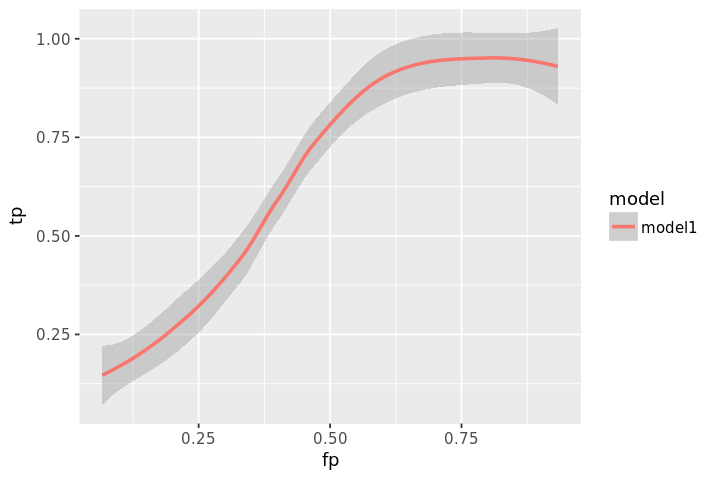

In [481]:
calctp_fp<-function(y_predict,y_real,th){
    y_est<-ifelse(y_predict<th,0,1)
    idx_cancer<-y_real==0
    idx_normal<-y_real==1

    M<-table(y_est,g.test_norm$diagnosis)

    if (ncol(M)==2 && nrow(M)==2){
        truePositive<-M[1,1]/(M[1,1]+M[2,1])
        falsePositive<-M[1,2]/(M[1,2]+M[2,2])
        c(tp=truePositive,fp=falsePositive)
    }else{
        c(tp=NA,fp=NA)
    }
}

y_predict<-predict(model_g,g.test_norm)
dfROC<-data.frame(th=unique(y_predict),tp=NA,fp=NA,model="model1")

for (i in 1:nrow(dfROC)){
    v<-calctp_fp(y_predict,g.test_norm$diagnosis,dfROC$th[i])
    dfROC$tp[i]<-v["tp"]
    dfROC$fp[i]<-v["fp"]
}

ggplot(data=dfROC,aes(x=fp,y=tp,color=model))+geom_smooth()

In [455]:
paste("Precision:", M[1,1]/(M[1,2]+M[1,1]))
paste("Exhausitivad:", M[1,1]/(M[2,1]+M[1,1]))
paste("Exactitud:",(M[1,1]+M[2,2])/sum(sum(M)))
p<-M[1,1]/(M[1,2]+M[1,1])
e<-M[1,1]/(M[2,1]+M[1,1])
b<-0.5
(1+b^2)*(p*e)/(b^2*p+e)

[1] "Precision: 0.8"

[1] "Exhausitivad: 0.615384615384615"

[1] "Exactitud: 0.730769230769231"

[1] 0.754717

### Parte 2

Realizar clusterización por k-means y uno basado en áboles (dendrograma). ¿Cual sería el número de clusters óptimo?  ¿Puedes identificar algún cluster interesante?

[1] "A vista de los resultados elijo 8 clusters"

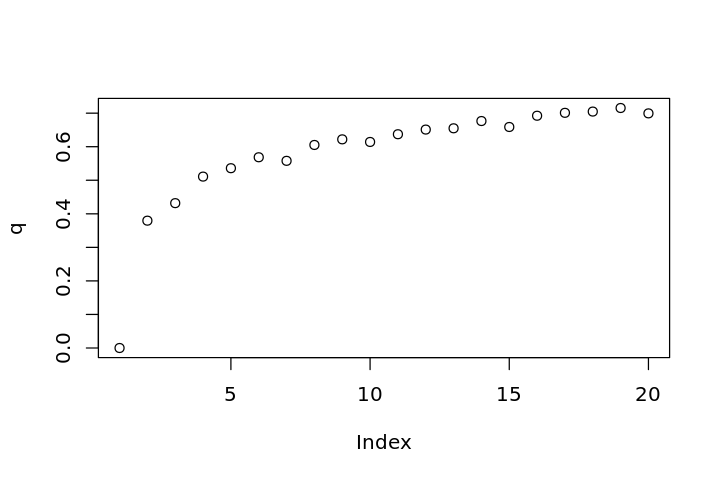

In [486]:
set.seed(1)
genexp_norm1<-genexp_norm
genexp_norm1$diagnosis<-NULL

q<-c()
for (k in 1:20){
    myclust<-kmeans(genexp_norm1,k)
    q[k]<-myclust$betweenss/myclust$totss
}
plot(q)

'A vista de los resultados elijo 8 clusters'

In [347]:
K<-kmeans(genexp_norm1,8)
table(genexp_norm$diagnosis,K$cluster)

   
     1  2  3  4  5  6  7  8
  C  0 14  4  1 11  7  1  5
  N  1  1  4 18  1  8  0 10

Warning message in dist(as.matrix(genexp_norm), method = "euclidean"):
"NAs introduced by coercion"

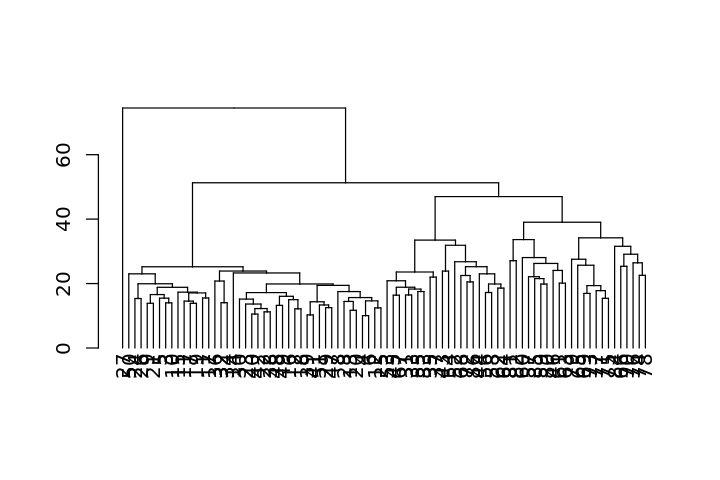

In [314]:
d <- dist(as.matrix(genexp_norm),method = "euclidean")
hc <- hclust(d,method="complete")
hcd <- as.dendrogram(hc)
plot(hcd)

In [498]:
table(genexp_norm$diagnosis,cutree(hc,4))

   
     1  2  3  4
  C 23  0 10 10
  N 19  1 10 13

In [504]:
'No he visto ningun cluster que tenga especial interes. Todos los clusters contienen parecido numero de genes con cancer que sin'

[1] "No he visto ningun cluster que tenga especial interes. Todos los clusters contienen parecido numero de genes con cancer que sin"

### Parte 3

Realizar un PCA, quedarse con los dos valores más representativos. Pintarlo en una nube de puntos donde los tejidos normales tendrán un color y los tejidos con cancer otro.

A partir de esta representación simplificada (con solo 2 valores más significativos) crear un modelo de regresión logística. Compara la curva ROC de este nuevo modelo con el de la *Parte 1*

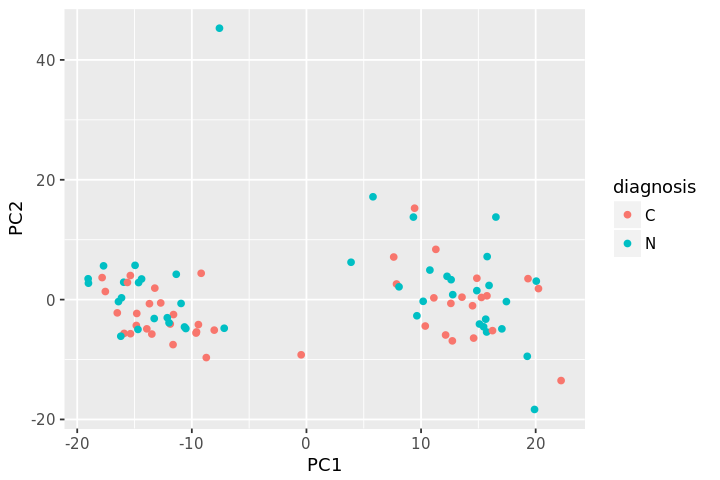

In [499]:
genexp_norm2<-genexp_norm
genexp_norm2$diagnosis<-NULL

prwdbc<-prcomp(genexp_norm2, center=TRUE, scale. = TRUE)

pca_data<-as.data.frame(prwdbc$x[,1:2])
#pca_data
pca_data$diagnosis<-diagnosis
ggplot(pca_data, aes(x=PC1,y=PC2,col=diagnosis))+geom_point()

        
y_factor C N
       C 3 7
       N 9 7

`geom_smooth()` using method = 'loess'
Warning message:
"Removed 5 rows containing non-finite values (stat_smooth)."

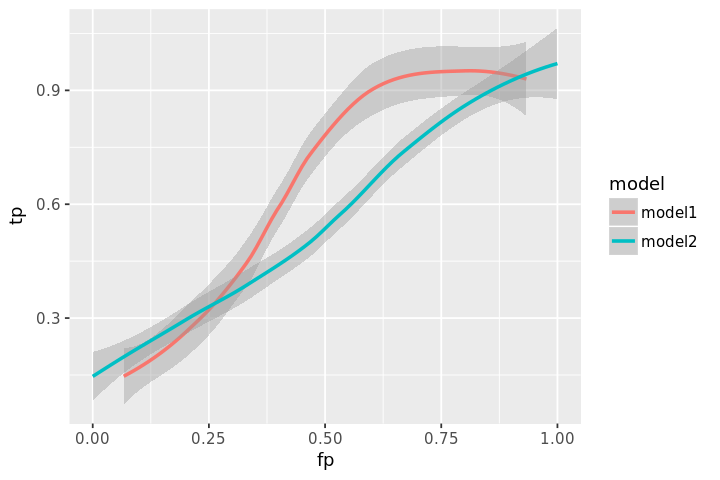

In [485]:
idx<-sample(1:nrow(pca_data),nrow(pca_data)*0.7)
pca.train_norm<-pca_data[idx,]
pca.test_norm<-pca_data[-idx,]

model_pca<-glm(data=pca.train_norm,formula = diagnosis ~ ., family=binomial(link='logit'))

y_predict1<-predict(model_pca, pca.test_norm)
y_factor<-as.factor(ifelse(y_predict1<0,"N","C"))
table(y_factor,pca.test_norm$diagnosis)

dfROC2<-data.frame(th=unique(y_predict1),tp=NA,fp=NA,model="model2")

for (i in 1:nrow(dfROC2)){
    v<-calctp_fp(y_predict1,pca.test_norm$diagnosis,dfROC2$th[i])
    dfROC2$tp[i]<-v["tp"]
    dfROC2$fp[i]<-v["fp"]
}

dfROC<-rbind(dfROC,dfROC2)
dfROC<-dfROC[order(dfROC$fp),]

ggplot(data=dfROC,aes(x=fp,y=tp,color=model))+geom_smooth()